# Library Install

model library install
```bash
pip install git+https://github.com/abcd-EGH/srnn-ae.git
```

In [104]:
!pip uninstall srnn-ae -q -y

In [105]:
!pip install git+https://github.com/abcd-EGH/srnn-ae.git -q

In [106]:
!pip show srnn-ae

Name: srnn-ae
Version: 0.1.11
Summary: Sparsely connections RNN + AutoEncoder Model for Anomaly Detection in Time Series
Home-page: https://github.com/abcd-EGH/srnn-ae
Author: Jihwan Lee (abcd-EGH)
Author-email: wlghks7790@gmail.com
License: MIT
Location: C:\Users\Jihwan\anaconda3\envs\ml_env\Lib\site-packages
Requires: matplotlib, numpy, pandas, scikit-learn, torch
Required-by: 


In [ ]:
!pip install arch

# Setting

In [160]:
from srnn_ae import SLAEE, TimeSeriesDataset, set_random_seed, hyperparameter_setting, read_dataset, data_plot_with_anomalies, train, test
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, average_precision_score, 
    cohen_kappa_score, roc_curve, precision_recall_curve,
    confusion_matrix
)
import matplotlib.pyplot as plt
import time
import datetime
import seaborn as sns
from arch import arch_model

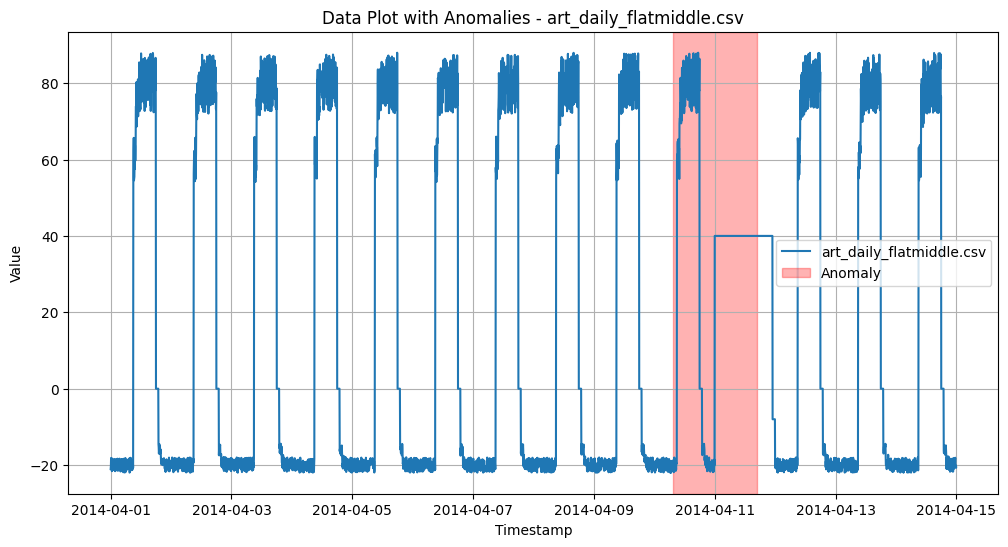

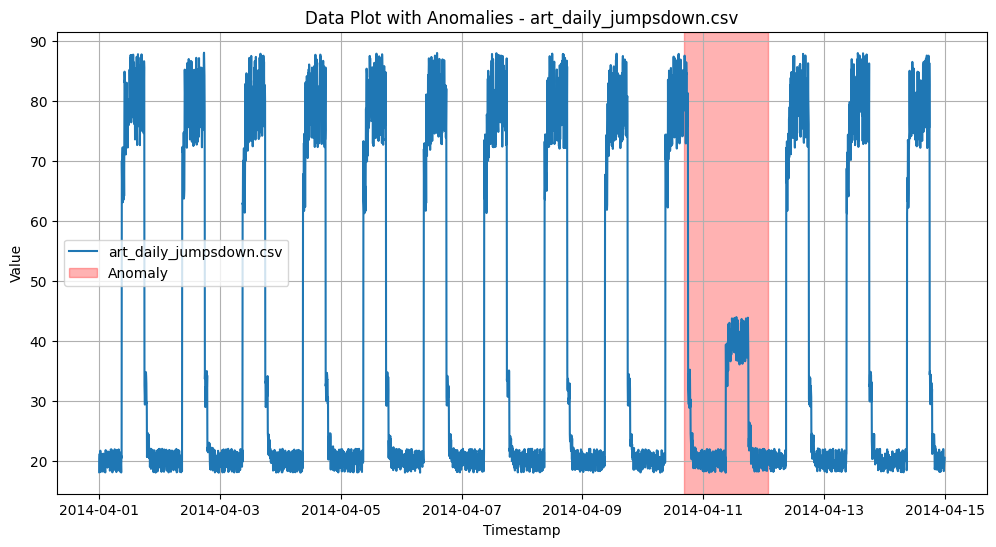

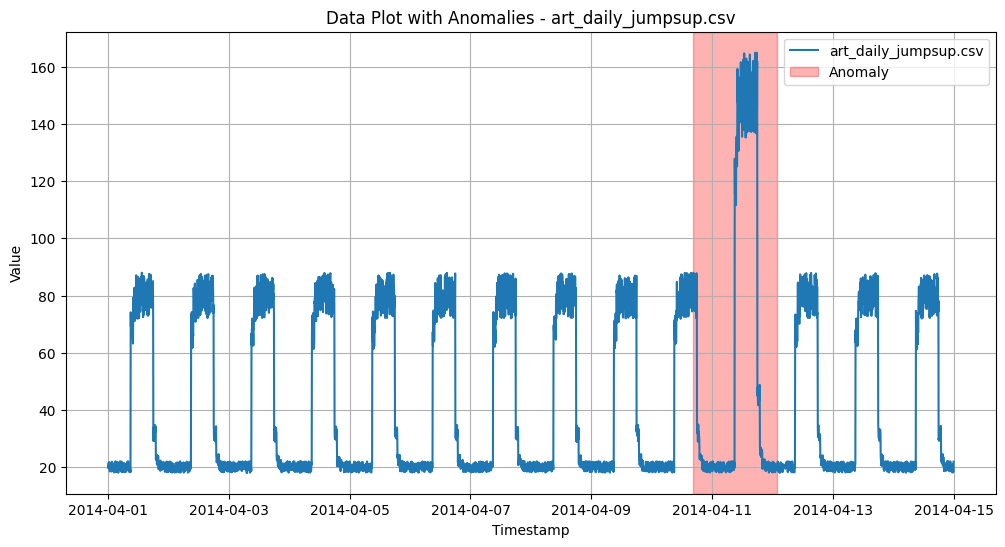

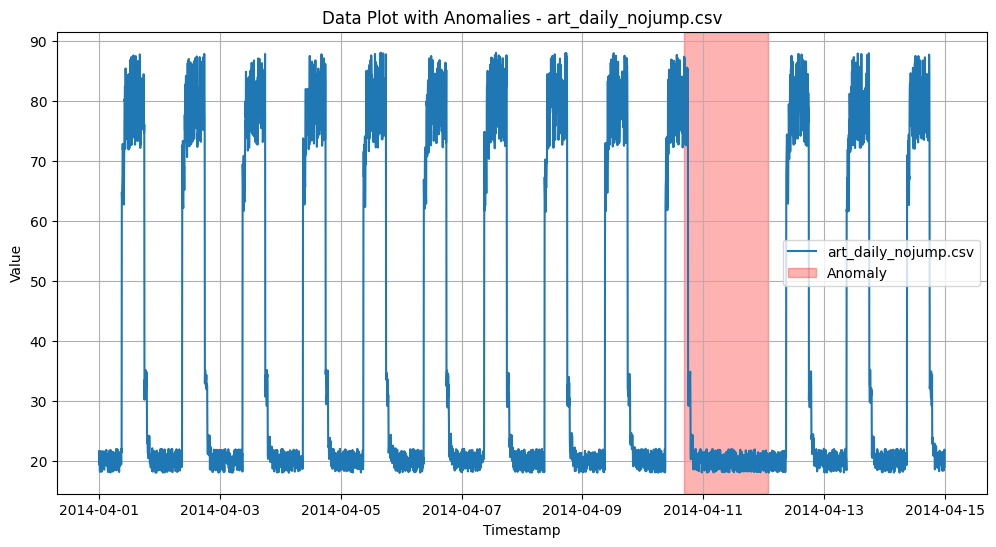

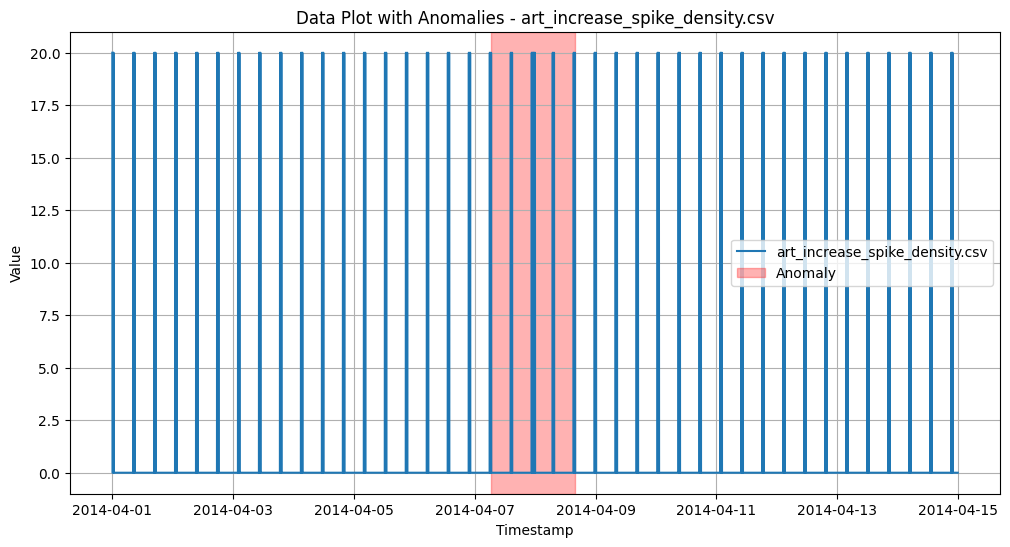

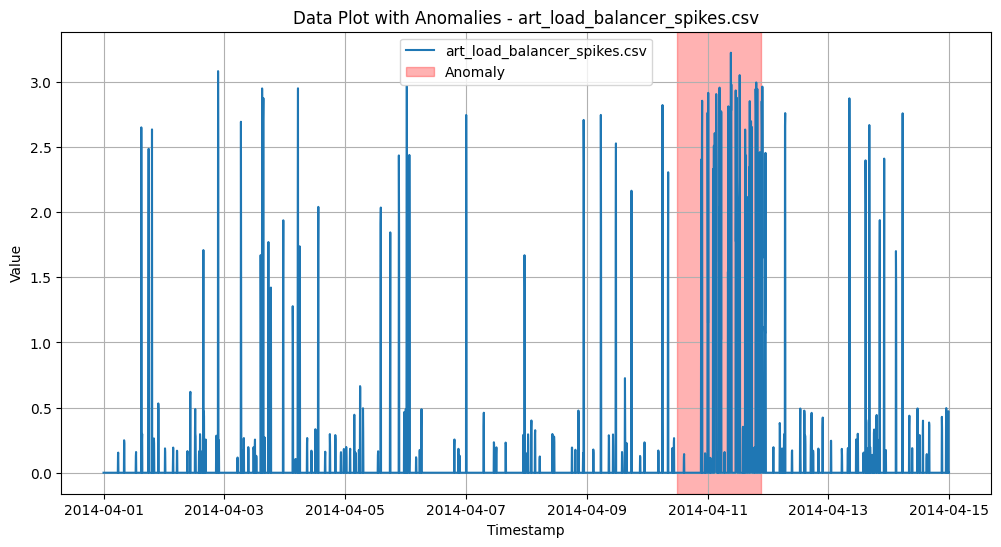

In [11]:
data_plot_with_anomalies(train_data_dir = './NAB/data/artificialWithAnomaly') # 이상치 라벨을 포함한 plot 생성 (폴더 단위)

In [98]:
set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=10, hidden_size=8, num_layers=1, batch_size=234, num_epochs=50, window_size=288, l1_lambda=1e-4, limit_skip_steps=10)
h='H1'
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)

model = SLAEE(
    N=args['N'], 
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# Prepare data and create Dataset
file_name = './NAB/data/artificialNoAnomaly/art_daily_small_noise.csv'
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:-1], abnormal_label[:-1]  # Remove last data point to fit window and batch size

window_size = args['window_size']
batch_size = args['batch_size']
stride = 4

# Create the full dataset
full_dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)

# Function to identify window indices where all labels are normal (1)
def get_normal_window_indices(dataset):
    normal_indices = []
    for idx in range(len(dataset)):
        _, _, window_labels = dataset[idx]
        if torch.all(window_labels == 1):
            normal_indices.append(idx)
    return normal_indices

# Get indices for training (only normal windows)
train_indices = get_normal_window_indices(full_dataset)

# Create Subsets for training and testing
train_dataset = Subset(full_dataset, train_indices)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print("Data Load Complete.")

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss() # MSELoss, L1Loss, SmoothL1Loss
optimizer = optim.AdamW(model.parameters(), lr=args['learning_rate'], weight_decay=1e-5)
print("Loss function & Optimizer Complete.")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

print("[Data]")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of batches in train dataloader: {len(train_dataloader)}")
print()

print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

Hyperparameter & Hypothesis Number Setting Complete.
Model Initialization Complete.
Processing file: artificialNoAnomaly/art_daily_small_noise.csv
Data Load Complete.
Loss function & Optimizer Complete.
[Args]
{'N': 10, 'input_size': 1, 'hidden_size': 8, 'output_size': 1, 'num_layers': 1, 'limit_skip_steps': 10, 'learning_rate': 0.001, 'l1_lambda': 0.0001, 'batch_size': 234, 'window_size': 288, 'num_epochs': 50, 'random_seed': 777}

[Model]
SLAEE(
  (autoencoders): ModuleList(
    (0-9): 10 x AutoEncoder(
      (encoder): Encoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
      )
      (decoder): Decoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
        (output_layer): Linear(in_features=8, out_features=1, bias=True)
      )
    )
  )
)

[Data]
Number of samples in train dataset: 936
Number of samples in test dataset: 936
Number of batches in trai

# Train

Epoch [1/50], Loss: 0.435385, (Duration: 44.57s, Current Time: 23:17:30, Estimated End Time: 23:53:54)
Epoch [10/50], Loss: 0.299587, (Duration: 45.43s, Current Time: 23:24:15, Estimated End Time: 23:54:32)
Epoch [20/50], Loss: 0.255748, (Duration: 45.22s, Current Time: 23:31:50, Estimated End Time: 23:54:26)
Epoch [30/50], Loss: 0.212713, (Duration: 45.13s, Current Time: 23:39:24, Estimated End Time: 23:54:27)
Epoch [40/50], Loss: 0.154904, (Duration: 45.54s, Current Time: 23:47:02, Estimated End Time: 23:54:38)
Epoch [50/50], Loss: 0.113632, (Duration: 46.40s, Current Time: 23:54:39, Estimated End Time: 23:54:39)
Training Complete.
Training loss plot saved to H1\training_loss.png
Training loss saved to H1\training_loss.csv


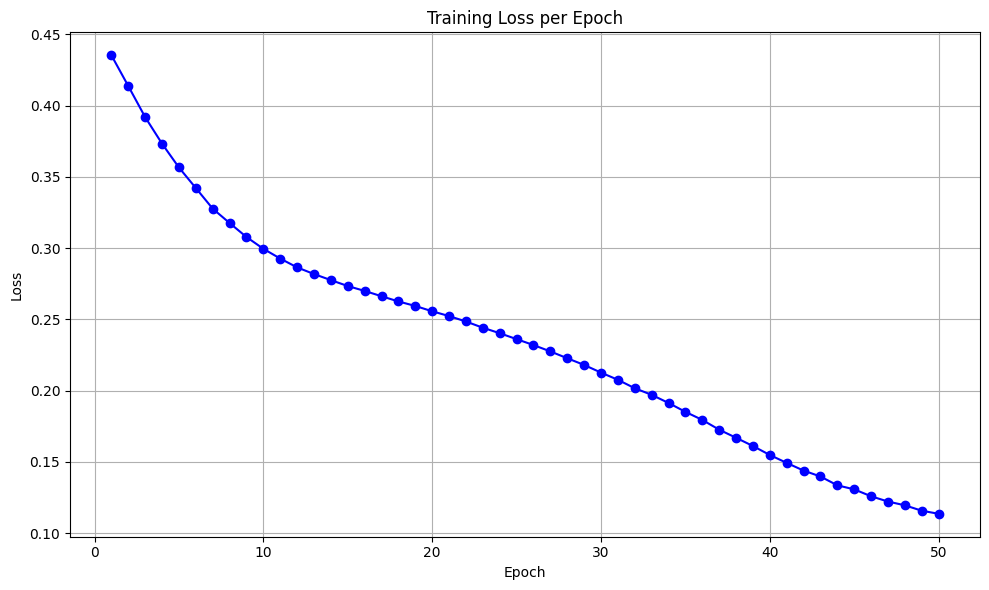

In [100]:
# 학습 실행
train(
    model=model,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    l1_lambda=args['l1_lambda'],
    num_epochs=args['num_epochs'],
    h=h
)
# LSTM+AE+GARCH -> 100 epoch, 0.002721 MSEloss

In [103]:
# 모델 가중치 저장
os.makedirs(h, exist_ok=True)
torch.save(model.state_dict(), f'{h}/ensemble_autoencoder_weights.pth')
print(f"모델 가중치가 {h}/ensemble_autoencoder_weights.pth'에 저장되었습니다.")

모델 가중치가 H1/ensemble_autoencoder_weights.pth'에 저장되었습니다.


# Test

In [186]:
model.load_state_dict(torch.load(f'{h}/ensemble_autoencoder_weights.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")

모델 가중치가 로드되었습니다.


Processing file: artificialWithAnomaly/art_daily_jumpsup.csv
Testing Complete.
Using static Reconstruction Error Threshold (95th percentile): 0.030456
[Classification Metrics]
Precision: 0.4406
Recall: 0.2214
F1-Score: 0.2947
ROC AUC: 0.6893
PR AUC: 0.3082
Cohen Kappa: 0.2443

Reconstruction error plot saved to H1/StaticThreshold\reconstruction_error_static_threshold.png


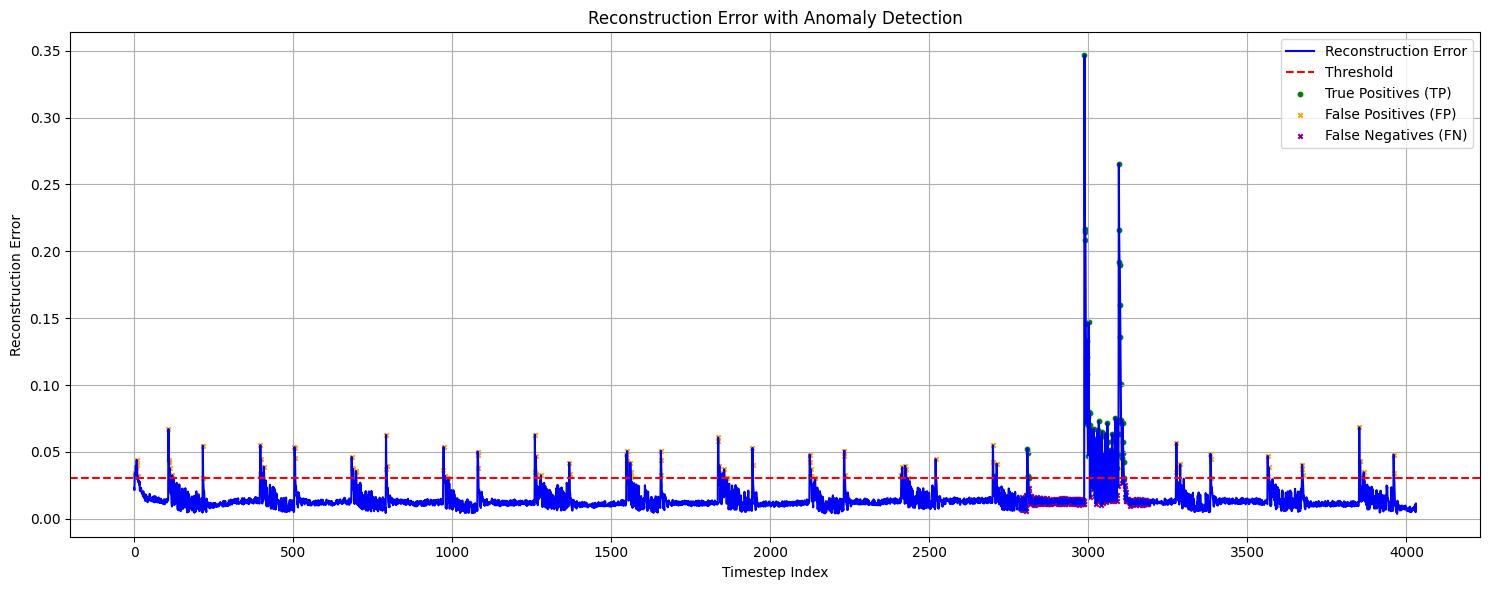

Actual vs Reconstructed Data plot saved to H1/StaticThreshold\actual_vs_reconstructed_data.png


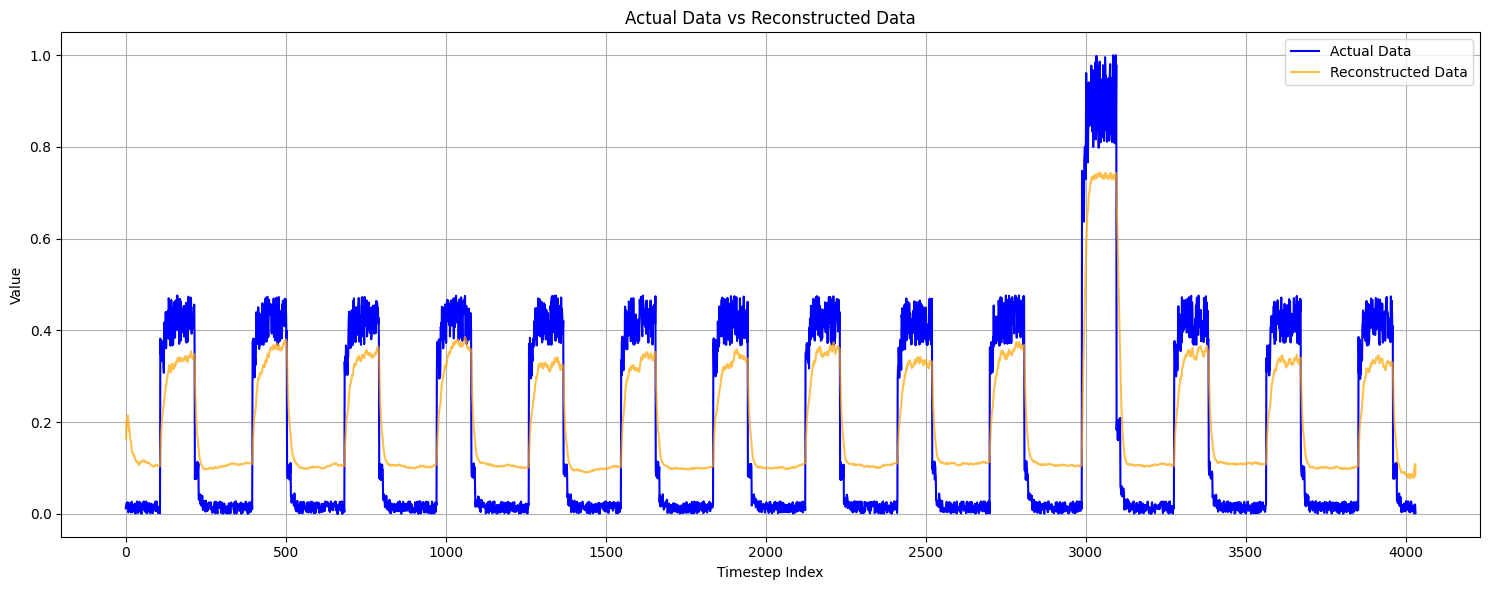

ROC curve plot saved to H1/StaticThreshold\roc_curve_all_data.png


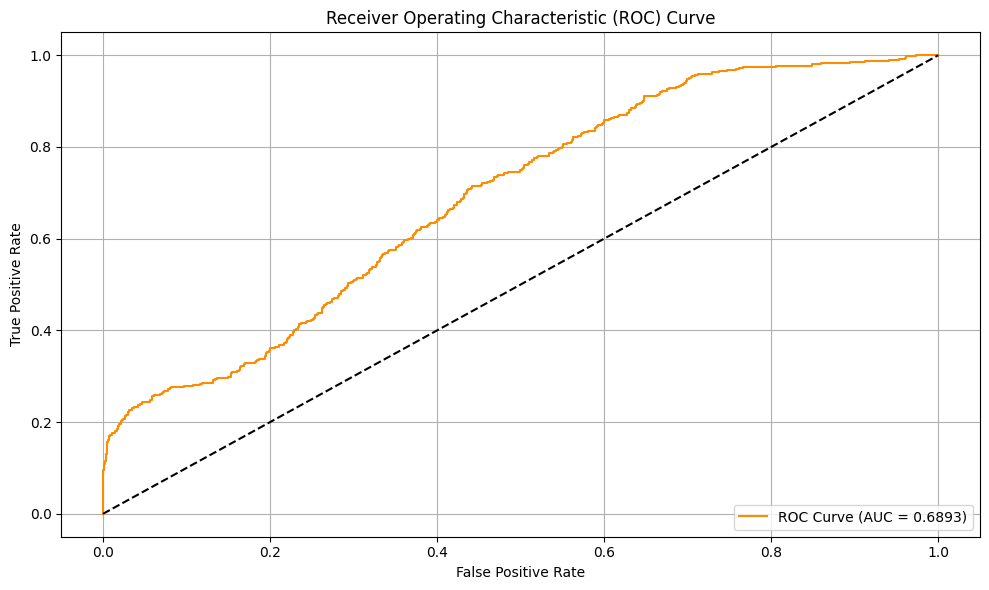

PR curve plot saved to H1/StaticThreshold\pr_curve_all_data.png


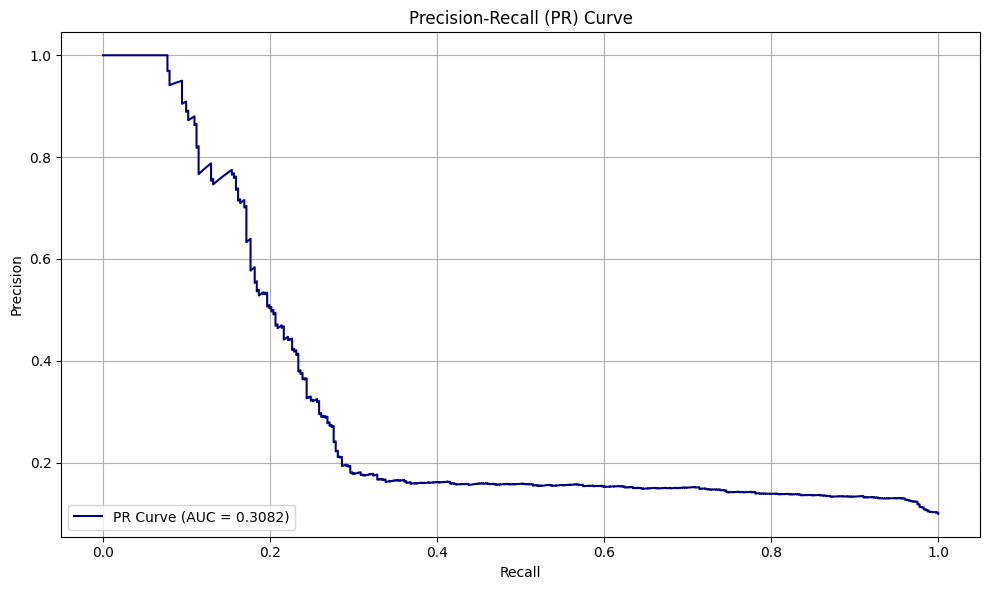

Confusion matrix plot saved to H1/StaticThreshold\confusion_matrix.png


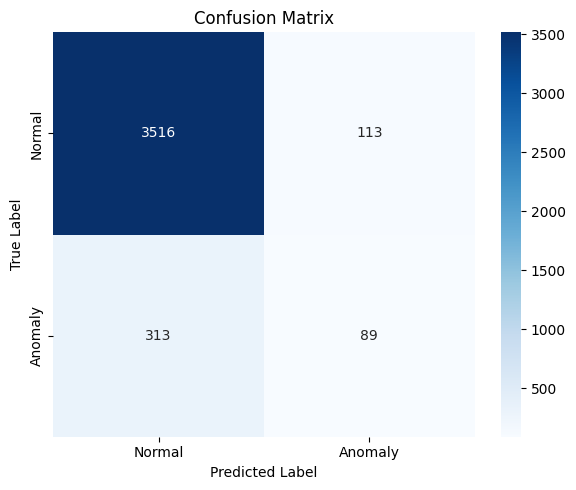

Reconstruction error with anomalies plot saved to H1/StaticThreshold\reconstruction_error_with_anomalies_static.png


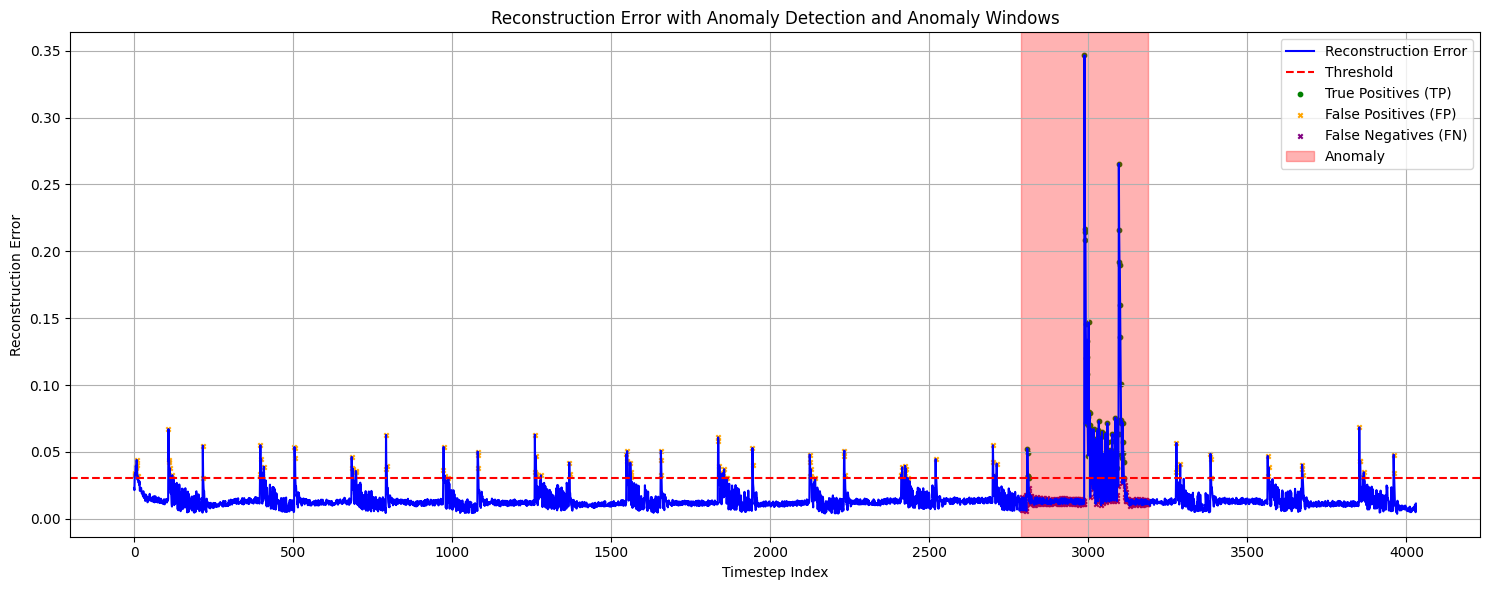

In [178]:
# 테스트 실행 (Static Threshold, threshold_percentile=95)
test_file_name = './NAB/data/artificialWithAnomaly/art_daily_jumpsup.csv'
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:-1], test_abnormal_label[:-1]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

test(
    model=model,
    dataloader=test_dataloader,
    device=device,
    total_length=len(test_abnormal_data),
    actual_data=test_abnormal_data, # plot 생성을 위한 실제 데이터 입력
    h=h+'/StaticThreshold',
    anomaly_labels=test_abnormal_label,
    threshold_method='static',
    threshold_percentile=95,
)

Processing file: artificialWithAnomaly/art_daily_jumpsup.csv
Testing Complete.
Using dynamic Reconstruction Error Threshold based on 20-window moving average and 1.75*std
[Classification Metrics]
Precision: 0.1139
Recall: 0.0448
F1-Score: 0.0643
ROC AUC: 0.5890
PR AUC: 0.2816
Cohen Kappa: 0.0085

Reconstruction error plot saved to H1/DynamicThresholdwithMA\reconstruction_error_moving_avg_threshold.png


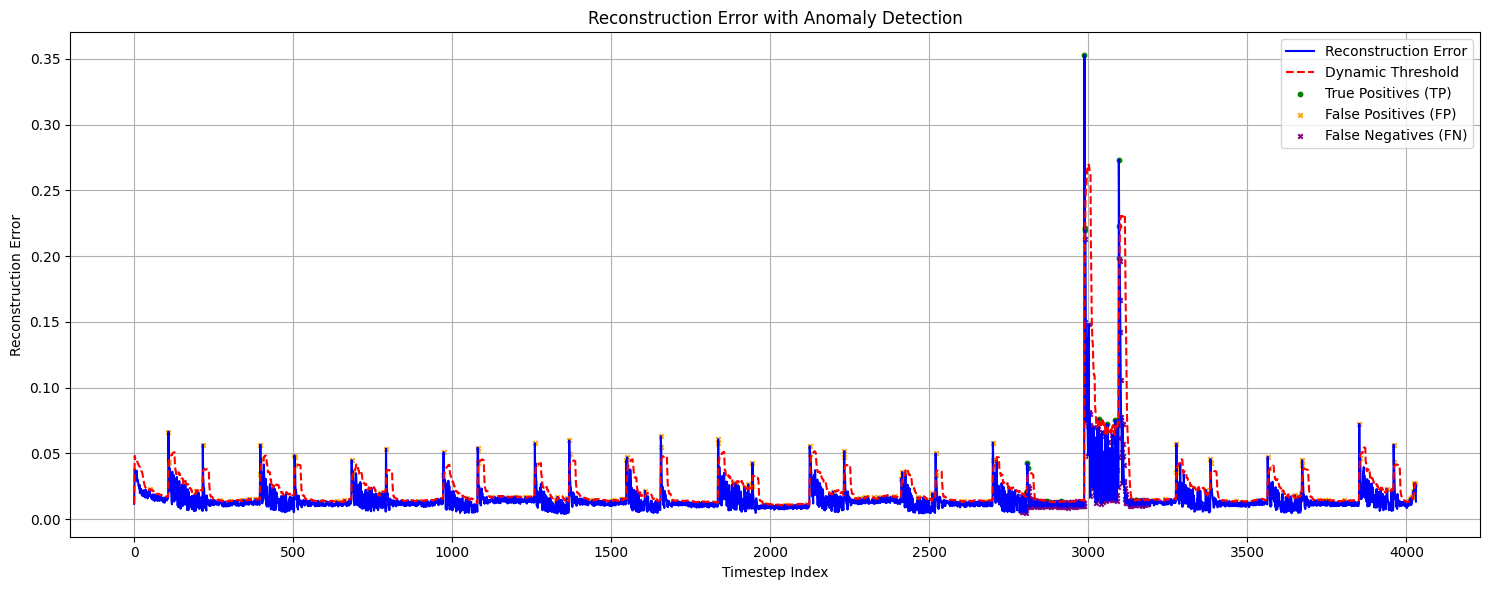

Actual vs Reconstructed Data plot saved to H1/DynamicThresholdwithMA\actual_vs_reconstructed_data.png


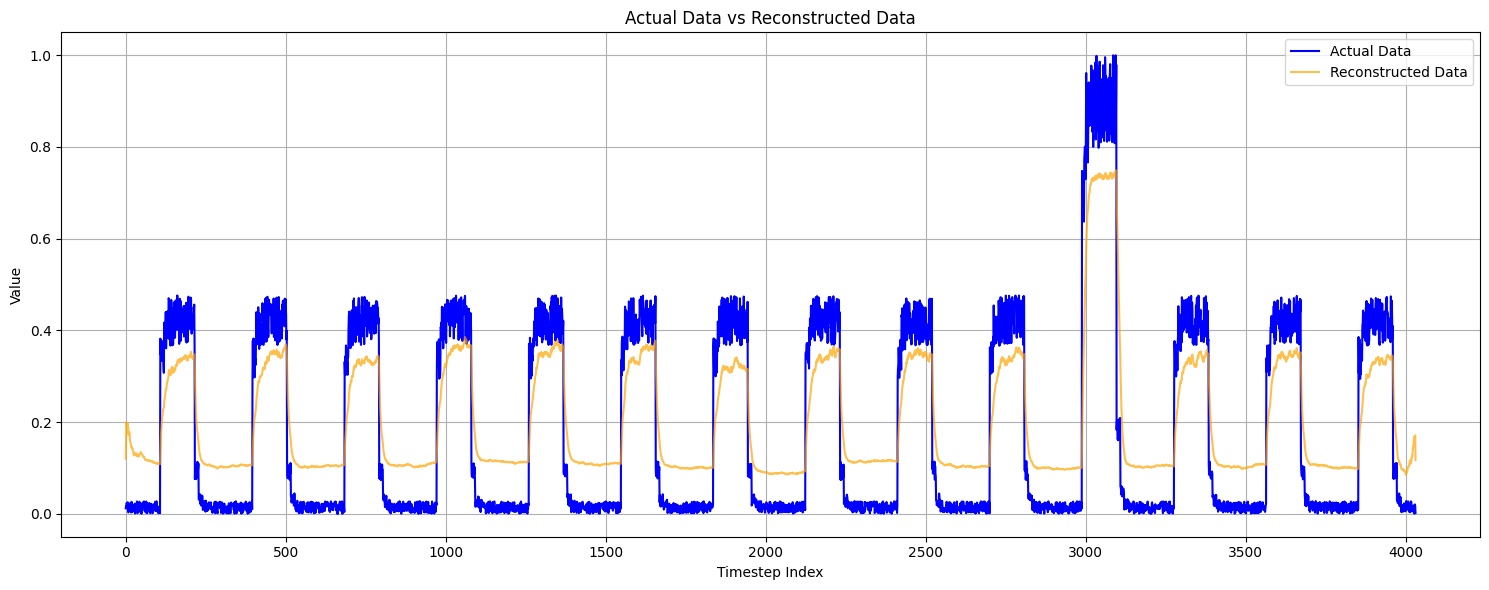

ROC curve plot saved to H1/DynamicThresholdwithMA\roc_curve_all_data.png


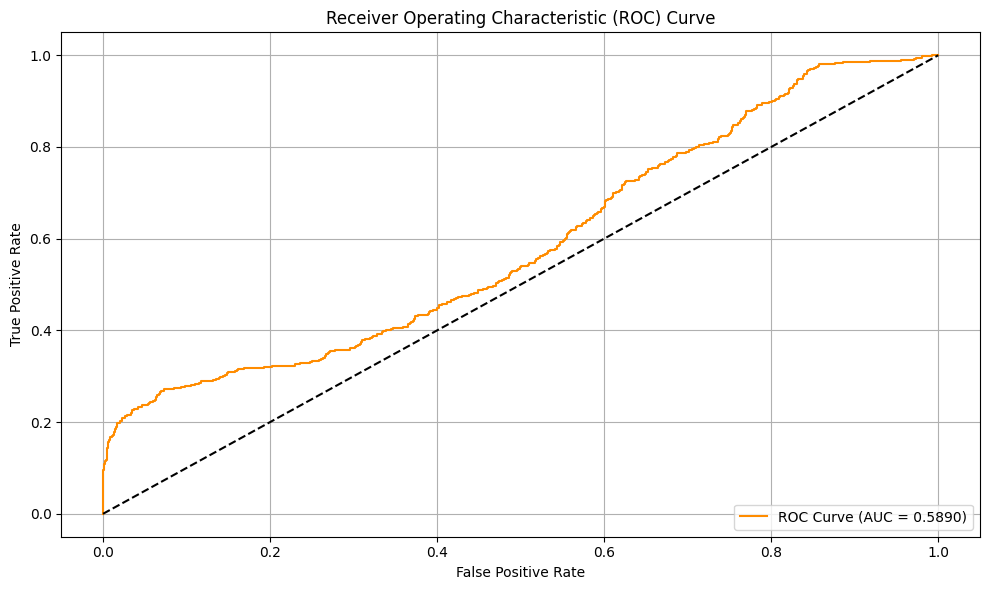

PR curve plot saved to H1/DynamicThresholdwithMA\pr_curve_all_data.png


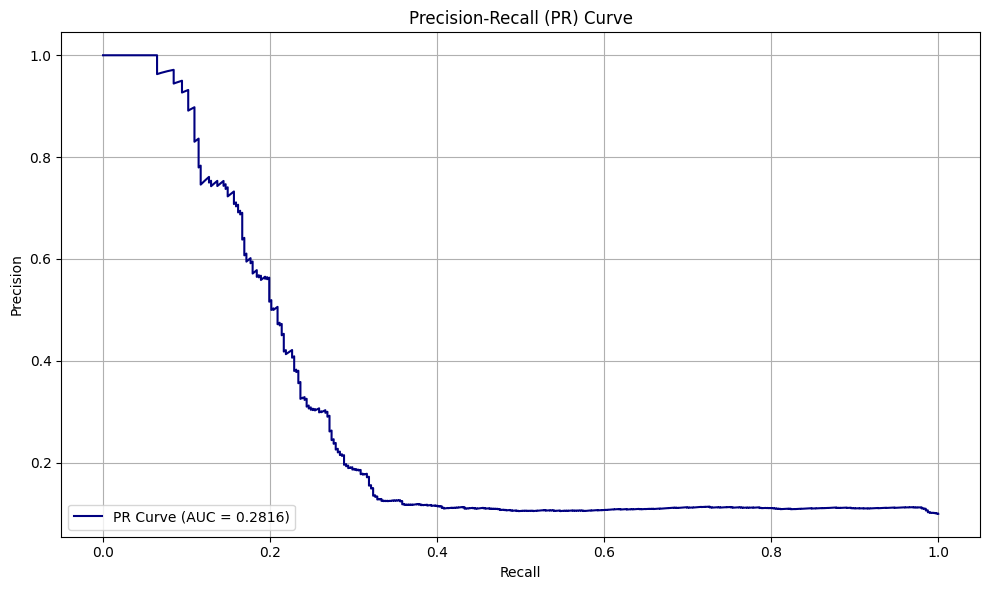

Confusion matrix plot saved to H1/DynamicThresholdwithMA\confusion_matrix.png


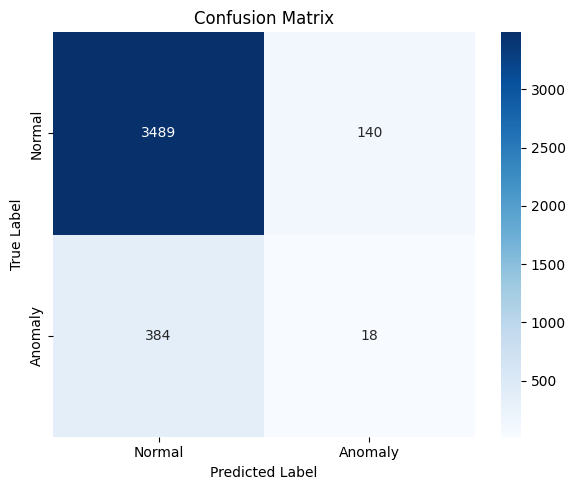

Reconstruction error with anomalies plot saved to H1/DynamicThresholdwithMA\reconstruction_error_with_anomalies_moving_avg.png


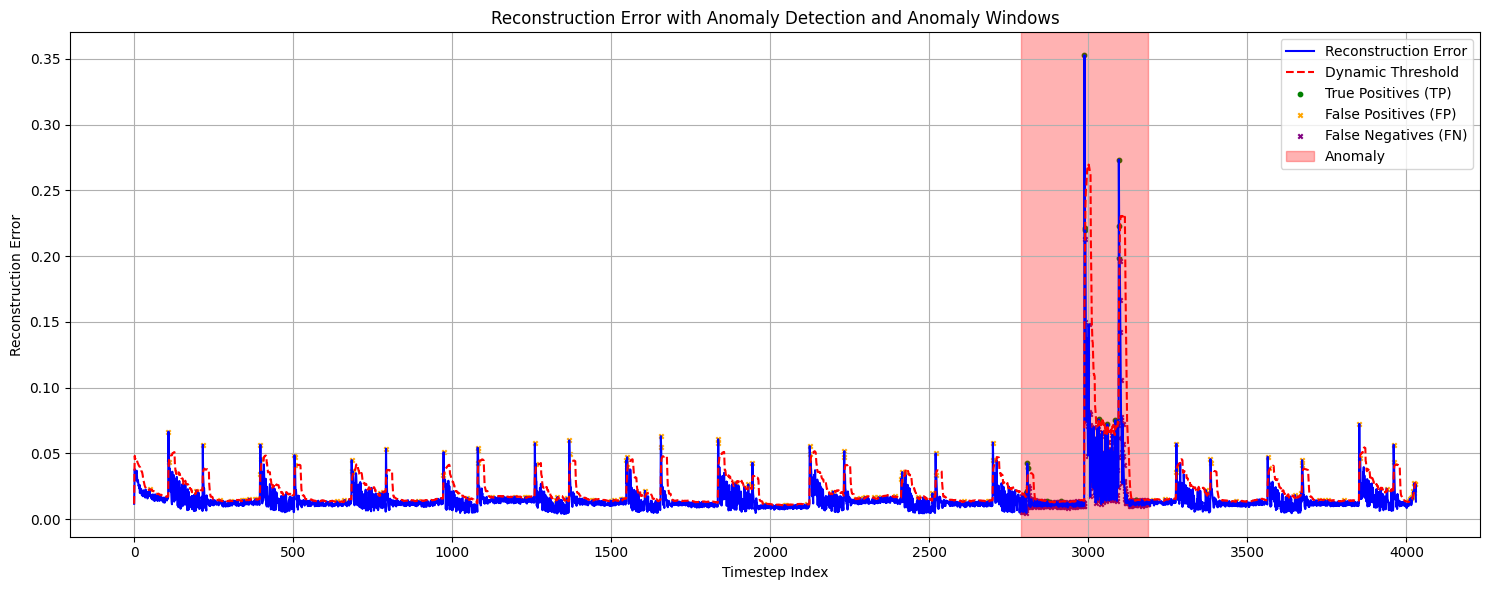

In [177]:
# 테스트 실행 (Dynamic Threshold, k=1.75)
test_file_name = './NAB/data/artificialWithAnomaly/art_daily_jumpsup.csv'
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:-1], test_abnormal_label[:-1]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

test(
    model=model,
    dataloader=test_dataloader,
    device=device,
    total_length=len(test_abnormal_data),
    actual_data=test_abnormal_data, # plot 생성을 위한 실제 데이터 입력
    h=h+'/DynamicThresholdwithMA',
    anomaly_labels=test_abnormal_label,
    threshold_method='moving_avg',
    k=1.75
)

Processing file: artificialWithAnomaly/art_daily_jumpsup.csv
Testing Complete.
Fitting GARCH(1,1) model on scaled reconstruction errors...
Using GARCH-based Dynamic Reconstruction Error Threshold with k=1.5
[Classification Metrics]
Precision: 0.1022
Recall: 0.7363
F1-Score: 0.1794
ROC AUC: 0.6955
PR AUC: 0.2932
Cohen Kappa: 0.0052

Reconstruction error plot saved to H1/DynamicThresholdwithGARCH\reconstruction_error_garch_threshold.png


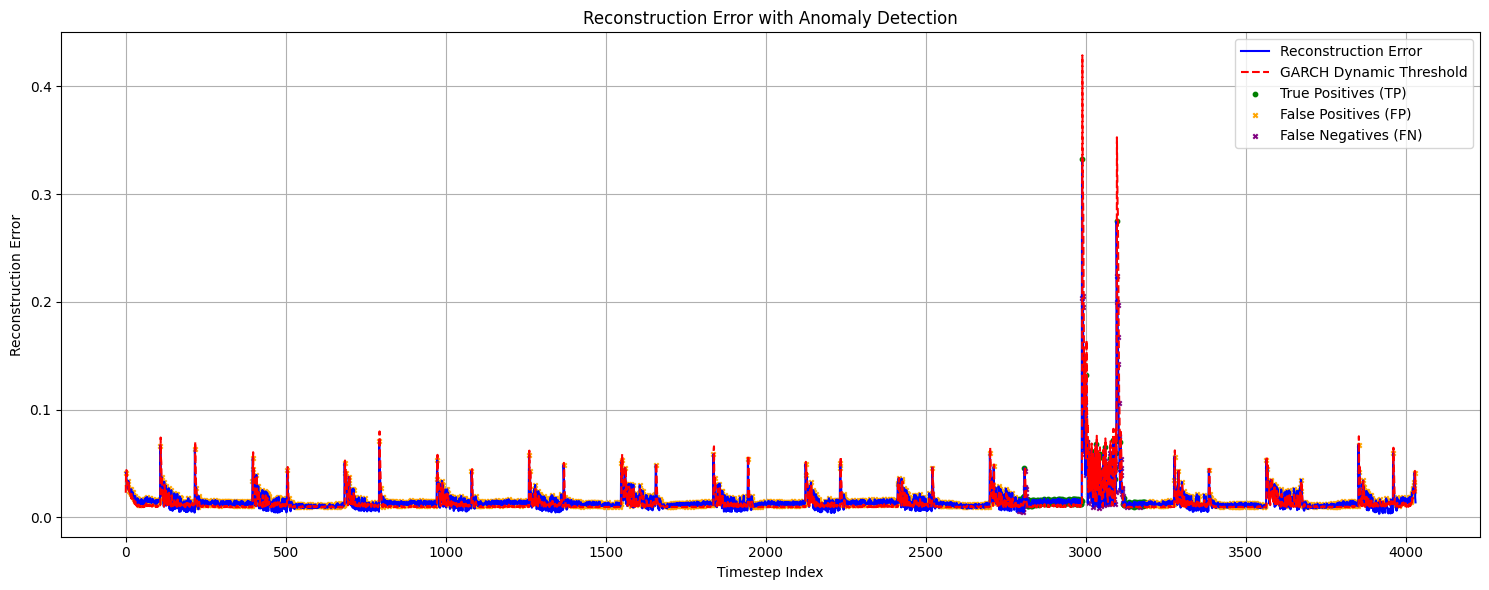

Actual vs Reconstructed Data plot saved to H1/DynamicThresholdwithGARCH\actual_vs_reconstructed_data.png


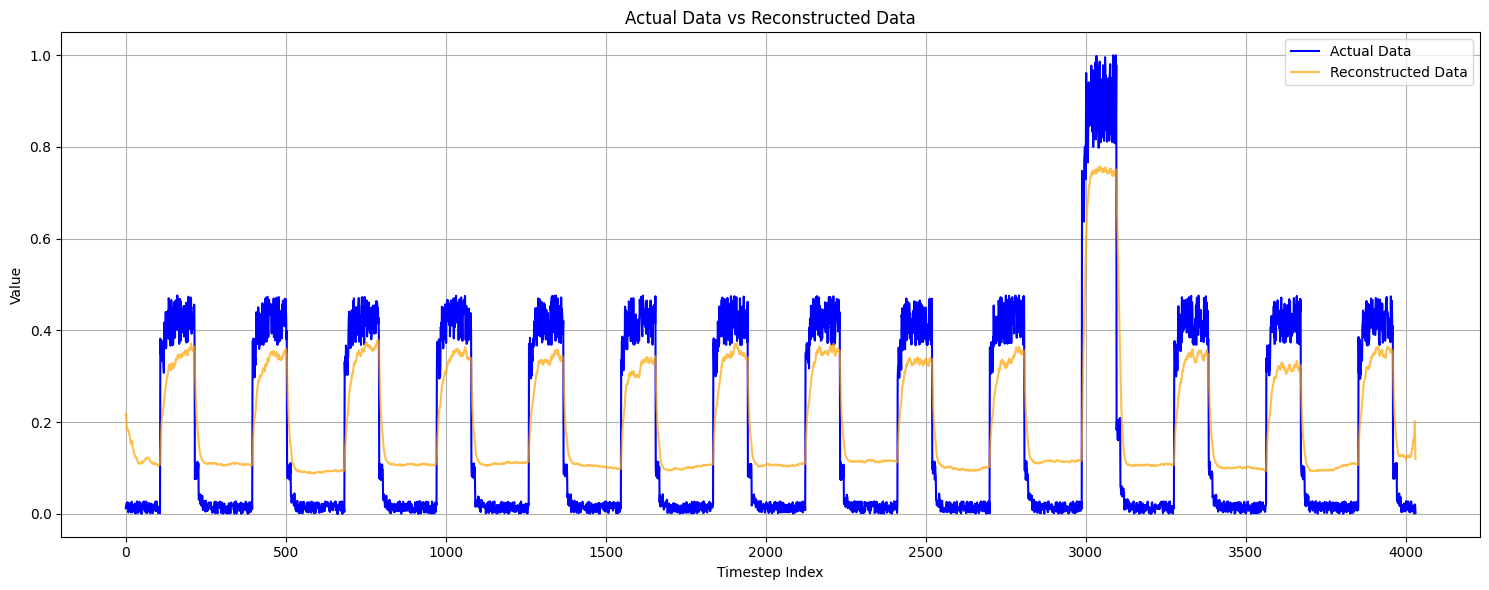

ROC curve plot saved to H1/DynamicThresholdwithGARCH\roc_curve_all_data.png


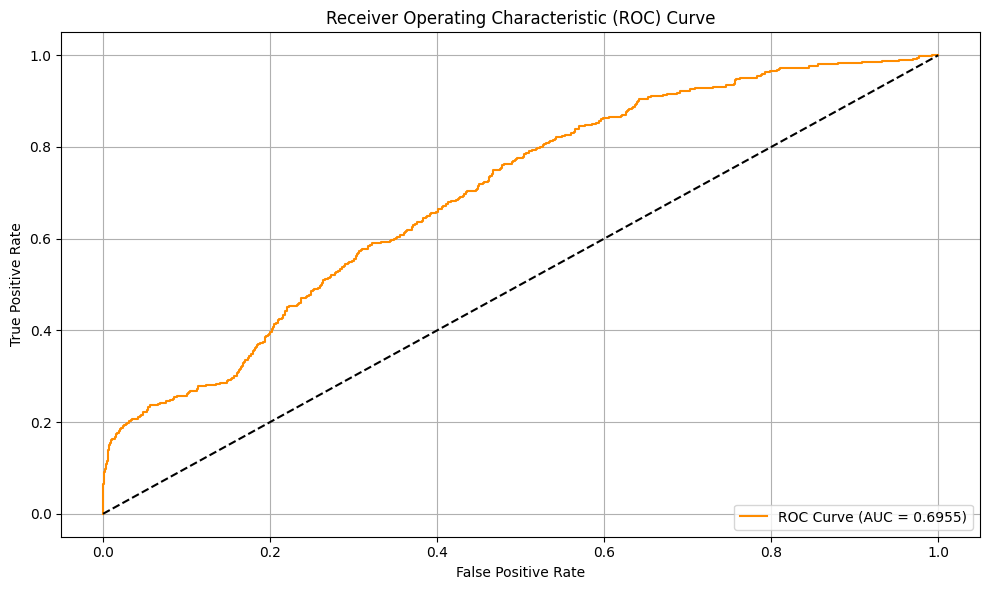

PR curve plot saved to H1/DynamicThresholdwithGARCH\pr_curve_all_data.png


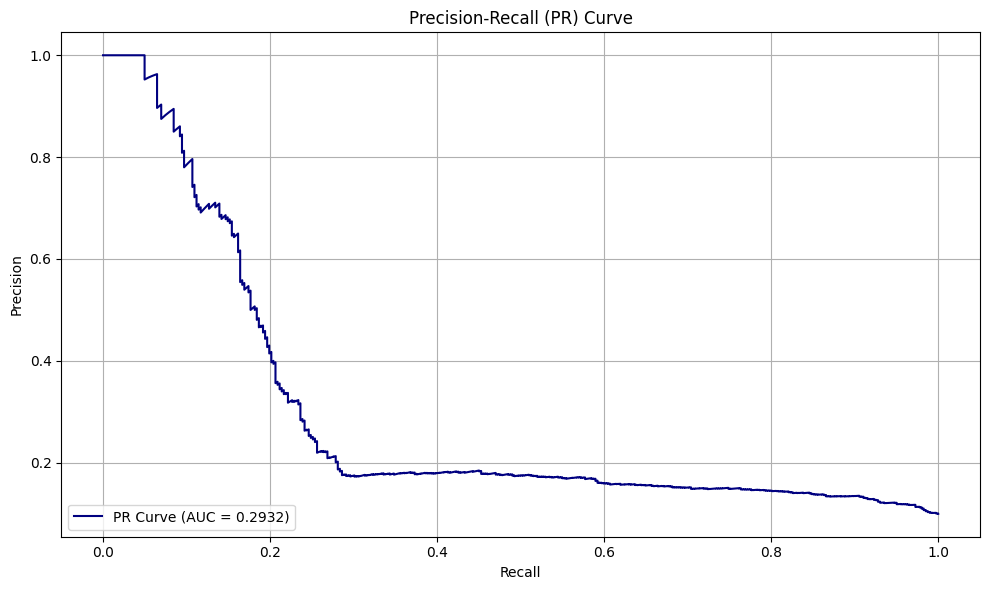

Confusion matrix plot saved to H1/DynamicThresholdwithGARCH\confusion_matrix.png


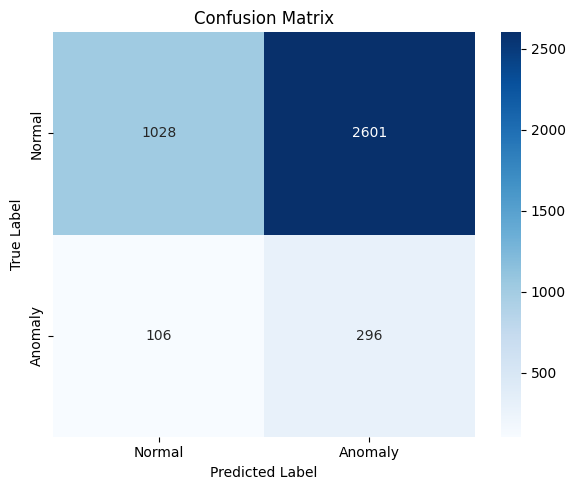

Reconstruction error with anomalies plot saved to H1/DynamicThresholdwithGARCH\reconstruction_error_with_anomalies_garch.png


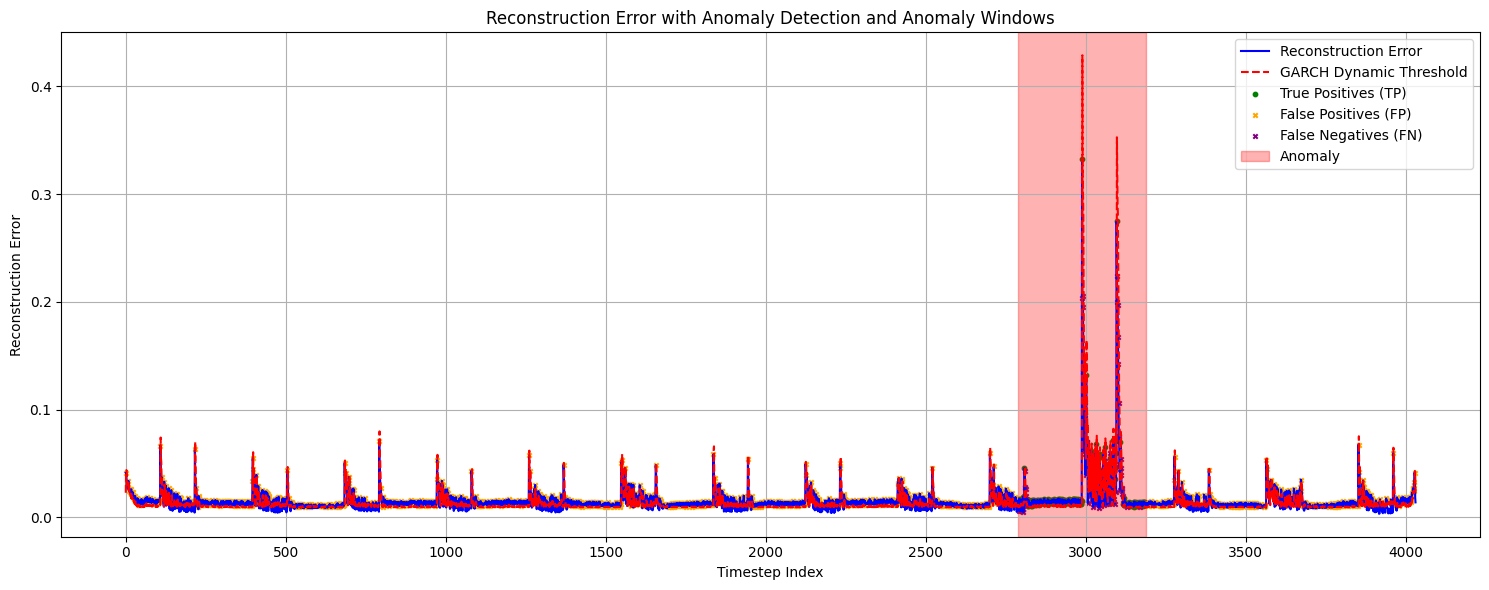

In [181]:
# 테스트 실행 (Dynamic Threshold, GARCH)
test_file_name = './NAB/data/artificialWithAnomaly/art_daily_jumpsup.csv'
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:-1], test_abnormal_label[:-1]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

test(
    model=model,
    dataloader=test_dataloader,
    device=device,
    total_length=len(test_abnormal_data),
    actual_data=test_abnormal_data, # plot 생성을 위한 실제 데이터 입력
    h=h+'/DynamicThresholdwithGARCH',
    anomaly_labels=test_abnormal_label,
    threshold_method='garch',
    k=1.5,
    scaling_factor=10
)

Processing file: artificialWithAnomaly/art_daily_jumpsup.csv
Testing Complete.
Fitting GARCH(1,1) model on scaled reconstruction errors...
Using GARCH-based Dynamic Reconstruction Error Threshold with k=1.1
[Classification Metrics]
Precision: 0.0959
Recall: 0.7935
F1-Score: 0.1711
ROC AUC: 0.6513
PR AUC: 0.3002
Cohen Kappa: -0.0083

Reconstruction error plot saved to H1/DynamicThresholdwithGARCH\reconstruction_error_garch_threshold.png


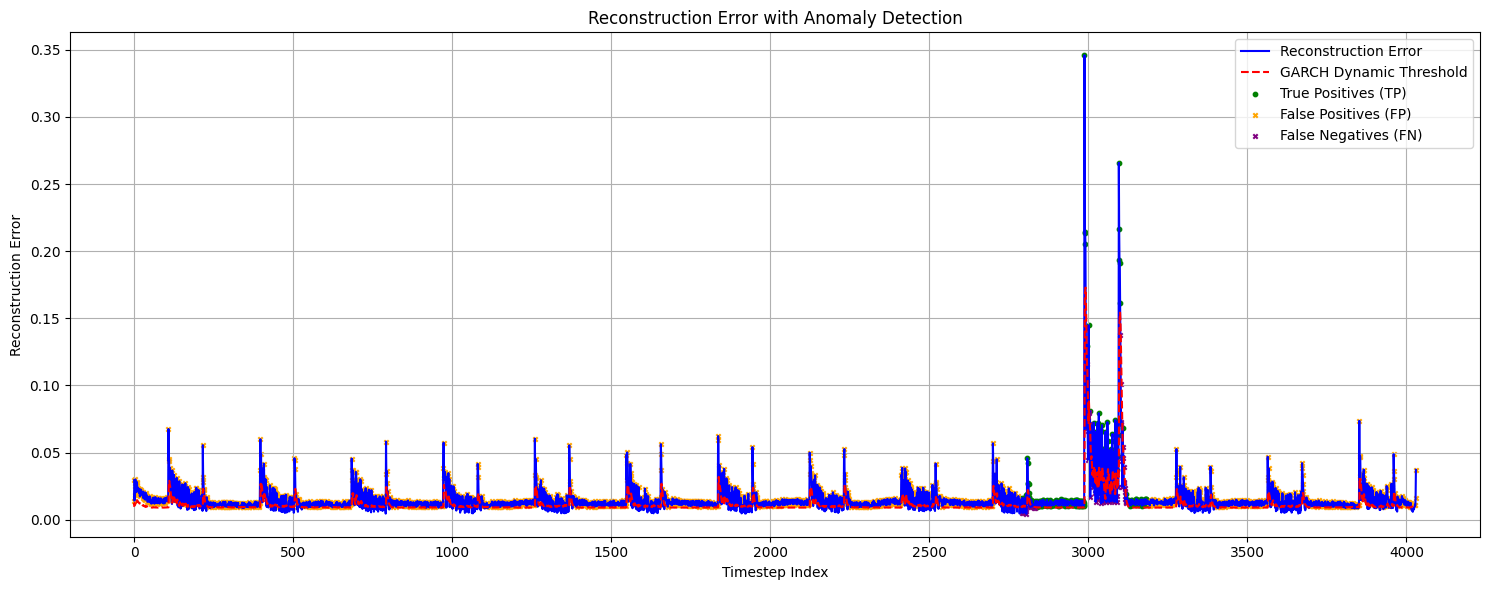

Actual vs Reconstructed Data plot saved to H1/DynamicThresholdwithGARCH\actual_vs_reconstructed_data.png


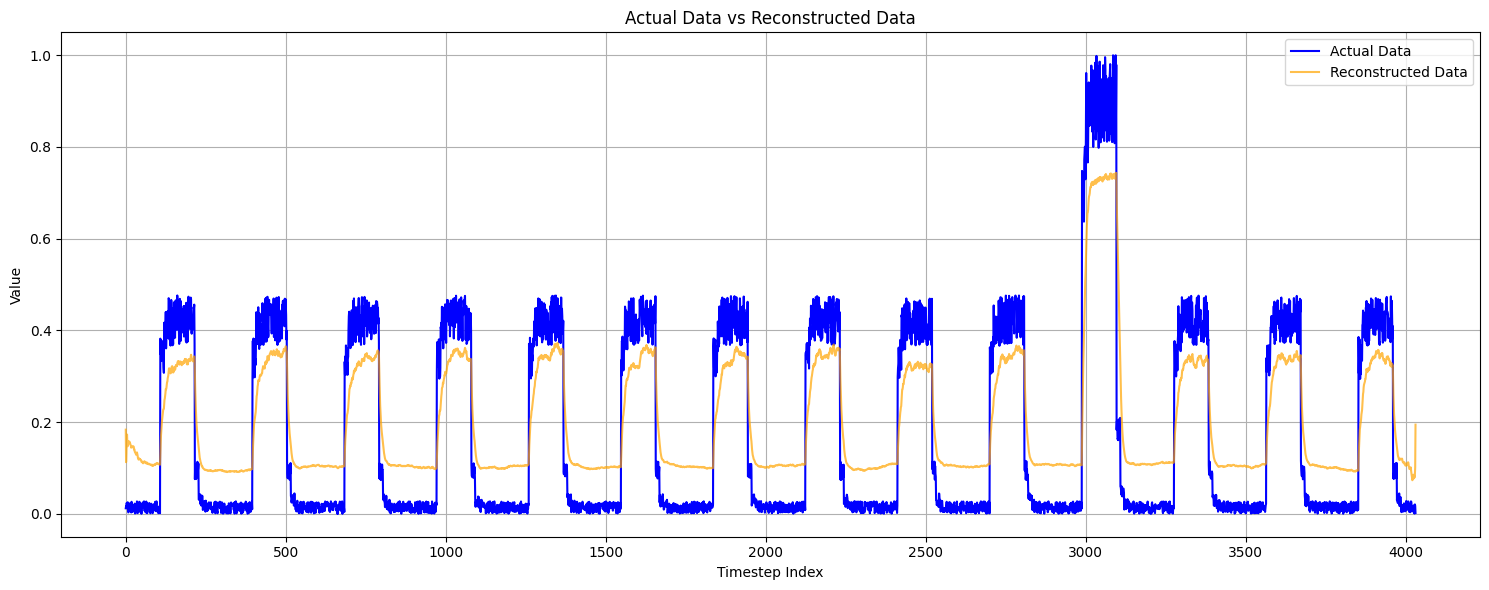

ROC curve plot saved to H1/DynamicThresholdwithGARCH\roc_curve_all_data.png


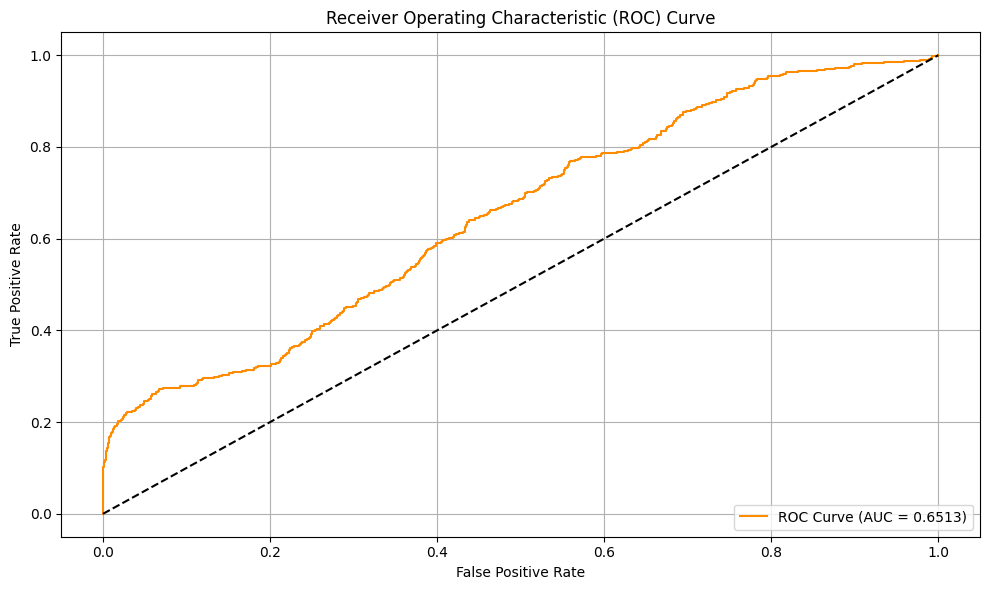

PR curve plot saved to H1/DynamicThresholdwithGARCH\pr_curve_all_data.png


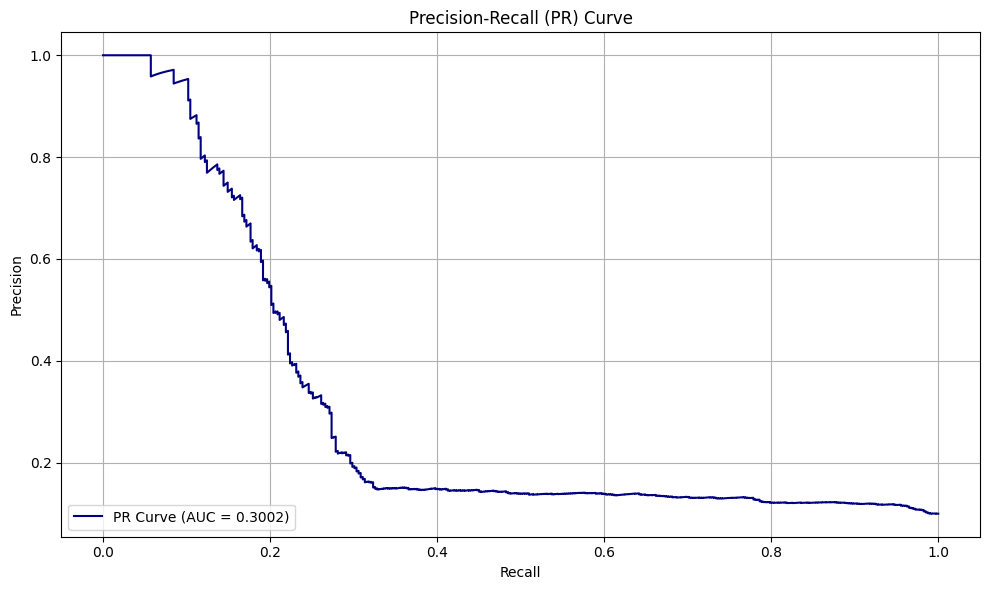

Confusion matrix plot saved to H1/DynamicThresholdwithGARCH\confusion_matrix.png


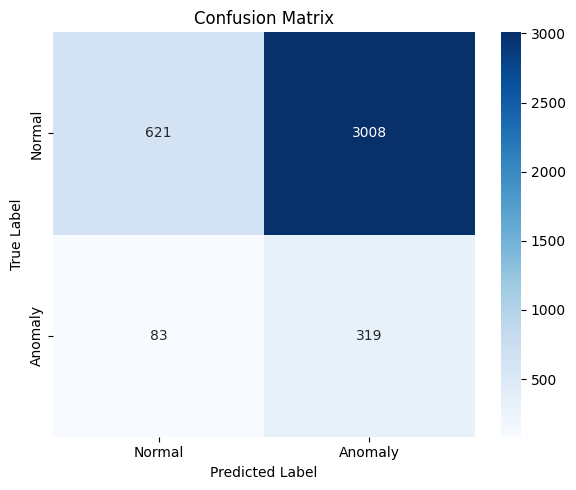

Reconstruction error with anomalies plot saved to H1/DynamicThresholdwithGARCH\reconstruction_error_with_anomalies_garch.png


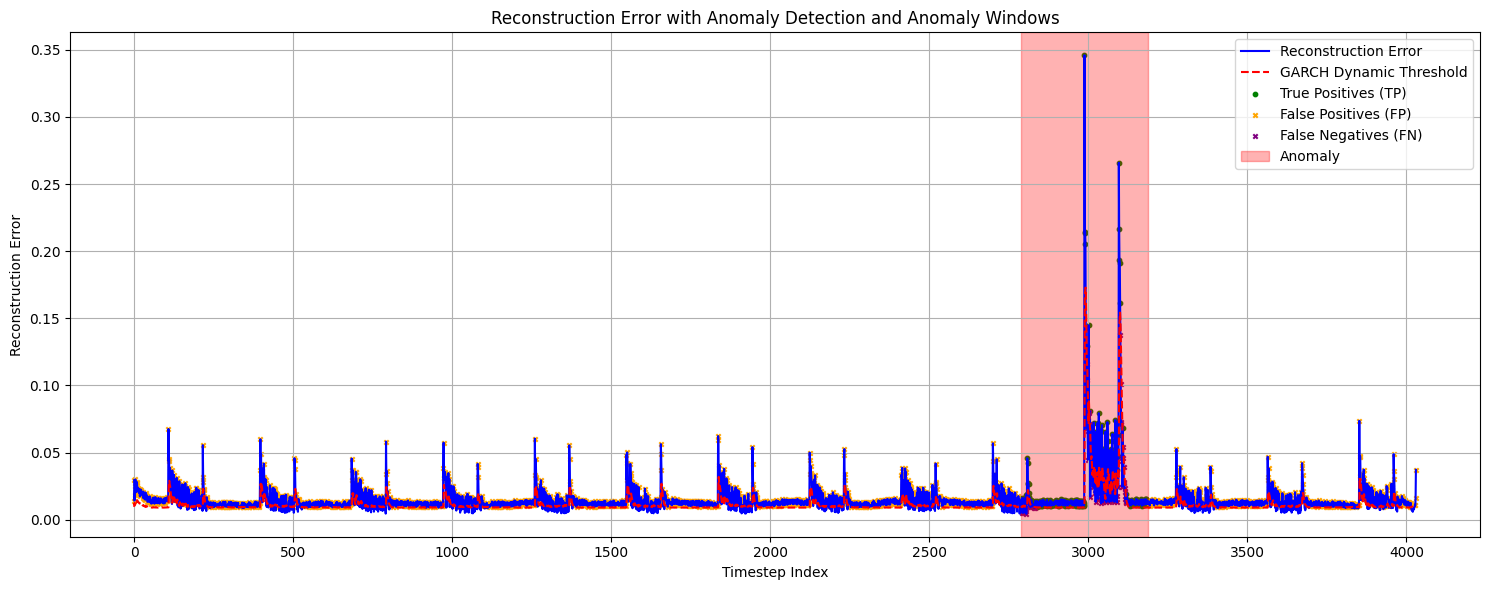

In [185]:
# 테스트 실행 (Dynamic Threshold, GARCH)
test_file_name = './NAB/data/artificialWithAnomaly/art_daily_jumpsup.csv'
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:-1], test_abnormal_label[:-1]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

test(
    model=model,
    dataloader=test_dataloader,
    device=device,
    total_length=len(test_abnormal_data),
    actual_data=test_abnormal_data, # plot 생성을 위한 실제 데이터 입력
    h=h+'/DynamicThresholdwithGARCH',
    anomaly_labels=test_abnormal_label,
    threshold_method='garch',
    k=1.1,
    scaling_factor=10
)